## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, RNN, Conv1D
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.rcParams.update({'figure.figsize': (16, 9)})
import matplotlib
import sklearn
import keras

In [2]:
import ta

## Load data

In [2776]:
data = pd.read_csv('../data/processed/company_id_94_processed.csv', parse_dates=True)
data = data[['txn_date', 
             'open', 'high', 'low', 
             'close',
             'vol', 
#              'month', 
             'day', 
#              'day_of_month'
            ]].sort_values(by='txn_date')
data['txn_date'] = pd.to_datetime(data['txn_date'])
# data = data[data['txn_date']< '2020-03-01']
data.set_index('txn_date', inplace=True, drop=True)
data['close_roc'] = data['close'].pct_change()
data['close_log_roc'] = np.log(1+data['close_roc'])
data['rsi'] = ta.momentum.RSIIndicator(close=data['close'], fillna=True).rsi()
data['macd_signal'] = ta.trend.MACD(close=data['close'], fillna=True).macd_signal()
data['macd_signal'] = ta.trend.MACD(close=data['close'], fillna=True).macd_signal()
data['chaikin_money_flow'] = ta.volume.ChaikinMoneyFlowIndicator(high=data['high'], low=data['low'], close=data['close'], volume=data['vol'], fillna=True).chaikin_money_flow()
data.dropna(inplace=True)
# data = data.resample('W').mean()
data.head()

,open,high,low,close,vol,day,close_roc,close_log_roc,rsi,macd_signal,chaikin_money_flow
txn_date,,,,,,,,,,,
1999-01-11,58.9,58.9,58.0,58.3,0.0,0,0.003442,0.003436,100.000000,0.003191,0.0
1999-01-12,58.6,58.7,58.4,58.5,0.0,1,0.003431,0.003425,100.000000,0.011398,0.0
1999-01-13,58.6,58.7,58.5,58.6,0.0,2,0.001709,0.001708,100.000000,0.023889,0.0
1999-01-14,58.5,59.5,58.1,58.8,0.0,3,0.003413,0.003407,100.000000,0.041546,0.0
1999-01-23,59.0,59.0,58.6,58.7,0.0,5,-0.001701,-0.001702,85.310605,0.059825,0.0


## Preprocessing

In [2777]:
# data.info()

In [2778]:
# data.describe()

In [2779]:
# min(data.index), max(data.index), data.shape[0]

In [2780]:
# data['chaikin_money_flow'].plot()
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend(['Close Price'])
# plt.show()

In [2781]:
# data['close_roc'].plot()
# plt.xlabel('Date')
# plt.ylabel('Close Price Rate Of Change')
# plt.show()

In [2782]:
# data['vol'].plot()
# plt.xlabel('Date')
# plt.ylabel('Trade Volume')
# plt.show()

In [2783]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [2784]:
def custom_ts_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [2785]:
x_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(-1,1))
data_x = x_scaler.fit_transform(data)
data_y = y_scaler.fit_transform(data[['close']])

In [2847]:
hist_window = 22
horizon = 1
TRAIN_SPLIT = int(len(data_x)*0.8)
x_train_multi, y_train_multi = custom_ts_data_prep(data_x, data_y, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_data_prep(data_x, data_y, TRAIN_SPLIT, None, hist_window, horizon)
split = int(len(x_val_multi)*0.5)
x_val_multi, y_val_multi, x_test_multi, y_test_multi = x_val_multi[: split], y_val_multi[:split], x_val_multi[:-split], y_val_multi[:-split]

In [2848]:
assert(x_train_multi.shape[0]  == y_train_multi.shape[0])
assert(x_val_multi.shape[0]  == y_val_multi.shape[0])

In [2849]:
# x_train_multi[:1], y_train_multi[:1]

In [2850]:
BATCH_SIZE = 128
BUFFER_SIZE = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [2851]:
# x_train_multi.shape

In [2852]:
lstm_model = Sequential([
    LSTM(40, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    LSTM(units=40,return_sequences=True),
    Dropout(0.1),
    LSTM(units=40,return_sequences=True),
    Dropout(0.1),
    LSTM(units=20),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=40,return_sequences=True),
#     Dropout(0.1),
#     LSTM(units=15),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [2853]:
model_path = r'../models/LSTM_Multivariate.h5'

In [2854]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = lstm_model.fit(train_data,
    epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data, validation_steps=50,verbose =1,
    callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
    verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min',
    verbose=0)])

Epoch 1/150
100/100 [==============================] - 16s 160ms/step - loss: 0.0653 - val_loss: 0.0136
Epoch 2/150
100/100 [==============================] - 13s 127ms/step - loss: 0.0155 - val_loss: 0.0110
Epoch 3/150
100/100 [==============================] - 12s 124ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 4/150
100/100 [==============================] - 12s 118ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 5/150
100/100 [==============================] - 12s 118ms/step - loss: 0.0090 - val_loss: 0.0035
Epoch 6/150
100/100 [==============================] - 12s 124ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 7/150
100/100 [==============================] - 13s 126ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 8/150
100/100 [==============================] - 12s 123ms/step - loss: 0.0058 - val_loss: 2.5783e-04
Epoch 9/150
100/100 [==============================] - 12s 123ms/step - loss: 0.0051 - val_loss: 2.1307e-04
Epoch 10/150
100/100 [==============================] - 

In [2855]:
model = tf.keras.models.load_model(model_path)

In [2856]:
model.summary()

Model: "sequential_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_373 (LSTM)              (None, 22, 40)            8320      
_________________________________________________________________
lstm_374 (LSTM)              (None, 22, 40)            12960     
_________________________________________________________________
dropout_195 (Dropout)        (None, 22, 40)            0         
_________________________________________________________________
lstm_375 (LSTM)              (None, 22, 40)            12960     
_________________________________________________________________
dropout_196 (Dropout)        (None, 22, 40)            0         
_________________________________________________________________
lstm_376 (LSTM)              (None, 20)                4880      
_________________________________________________________________
dense_141 (Dense)            (None, 1)              

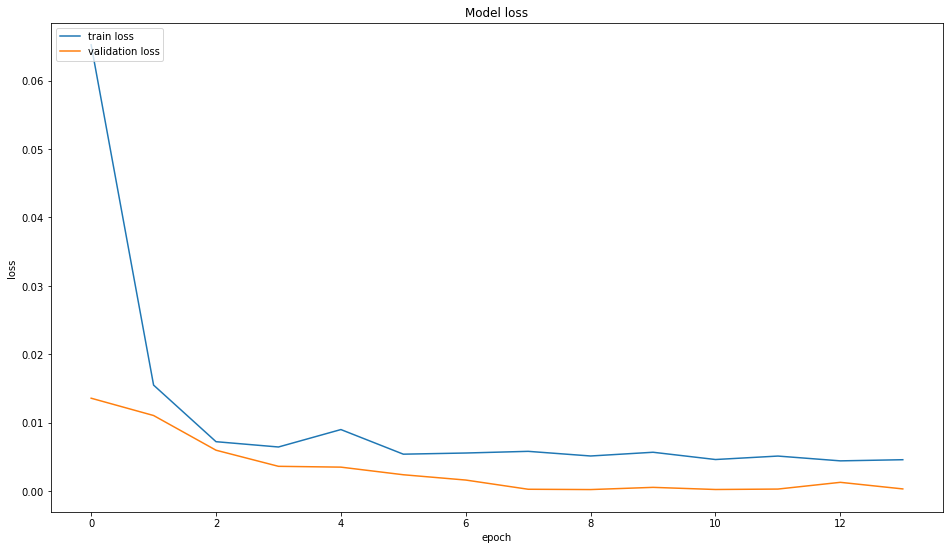

In [2857]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [2858]:
result_inv_trans = model.predict(x_test_multi)

In [2859]:
y_val_ = [y_scaler.inverse_transform(y[0].reshape(-1,1))[0][0] for y in y_test_multi]
y_pred_ = [y_scaler.inverse_transform(np.array(y[0]).reshape(-1,1))[0][0] for y in result_inv_trans]

In [2860]:
timeseries_evaluation_metrics_func(y_val_, y_pred_)

Evaluation metric results:-
MSE is : 11.075786114735813
MAE is : 2.8293697790666066
RMSE is : 3.328030365657112
MAPE is : 10.256039717239641
R2 is : 0.33190190410194953



In [2861]:
# np.std(y_val_), np.mean(y_val_) #(4.016922584171439, 28.52873134328358)

In [2862]:
# [y_scaler.inverse_transform(y[0].reshape(-1,1))[0][0] for y in y_val_multi]

In [2863]:
a = pd.DataFrame([y_scaler.inverse_transform(y[0].reshape(-1,1))[0][0] for y in y_val_multi], index=np.array(data.index)[-2*split:-split])
b = pd.DataFrame(y_val_, index=data[-len(y_val_):].index)
c = pd.DataFrame(y_pred_, index=data[-len(y_pred_):].index)

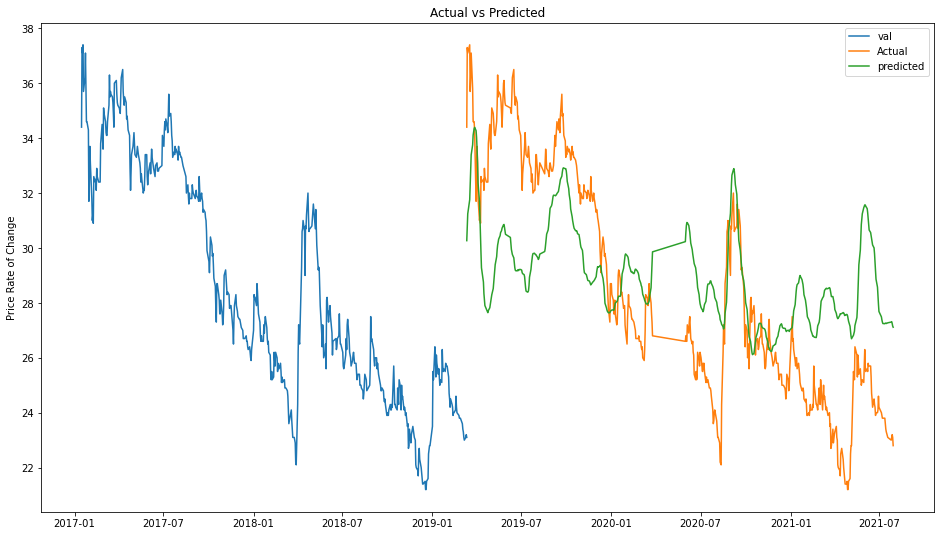

In [2864]:
plt.plot(a )
plt.plot(b)
plt.plot(c)
plt.title("Actual vs Predicted")
plt.ylabel("Price Rate of Change")
plt.legend(('val','Actual','predicted'))
plt.show()